# Introduction  

Welcome! In this notebook, we will explore the workings of a Generative Adversarial Network (GAN), specifically CycleGAN, which transforms Monet's masterpieces into photo-realistic images and converts landscape photos into Monet-style paintings.  

This is my first time working extensively with deep learning code using TensorFlow.  

Therefore, this notebook not only investigates the structure of GANs but also delves into the coding framework of deep learning in TensorFlow.

For those already familiar with TensorFlow, some explanations may seem redundant; I appreciate your understanding.  

I hope that those new to TensorFlow will find the information helpful and valuable.  

# Import libraries and load data

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

# TPU setting
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path('monet-gan-getting-started')

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All images provided for the competition are already resized to 256x256 pixels.  

Since these are RGB images, the number of channels is set to 3.  

Additionally, we need to scale the pixel values to a range of [-1, 1]. This scaling is important for stabilizing the training process of the generative model.  

Because we are building a generative model, labels and image IDs are not necessary, so we will only extract and return the image from the TFRecord.

# EDA (Exploratory Data Analysis)

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

We define the function to extract the image from the files.

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames) 
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's  visualize a photo example and a Monet example.

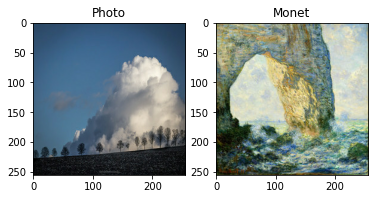

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Model Architecture
# U-Net 
* A widely used deep learning model primarily for image segmentation tasks.
* A CNN based architecture 
* It uses skip connection between corresponding encoder and decoder layers.  

CycleGAN objective function and loss function will be explained below.

# Skip connection

Just like the ResNet, the popular CNN architecture, we use skip connections to pass upstream features directly to the downstream layers.  

By concatenating or adding these features, we help preserving important information and mitigate the risk of vanishing or exploding gradients, thereby improving training stability.

# Downsample

In [9]:
OUTPUT_CHANNELS = 3 # RGB

def downsample(filters, kernel_size, apply_instancenorm=True):
    # filters: # of ch; # of filters in Conv2D layer
    # kernel_size of the Conv Kernel e.g., 3x3, 4x4, etc
    # flag whether to apply instance normalization
    
    # sampling initial weights for Conv2D kernel, from N(0, 0.02)
    initializer = tf.random_normal_initializer(0., 0.02)
    # gamma is a scale parameter for InstanceNormalization
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)    

    # generate conv-block by keras.Sequential
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, kernel_size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    # filters: # of ch for feature maps
    # kernel size: e.g., 3x3, 4x4, etc
    # stride=2: downsampling to half the inputs' H and W
    # padding='same': to retain the image size (zero padding)
    # use_bias=False: because we use the InstanceNorm which handles bias correction
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # activation function
    result.add(layers.LeakyReLU())

    return result

# Upsample
`Upsample` does the opposite of downsample and increases the dimensions of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [10]:
def upsample(filters, kernel_size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, kernel_size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

# Types of Normalization

There are mainly three popular normalizations; 
* Batch Normalization
* Layer Normalization
* Instance Normalization

Let's look at them one by one;

1. Batch Normalization  
* Good for CNN 
* Calculation target:  
whole mini-batch  
* It normalizes each mini-batch with the mini-batch mean and variance;
$$\mu_{B}=\frac{1}{m} \sum\limits_{i=1}^m x_{i}$$
$$\sigma_{B}^2=\frac{1}{m} \sum\limits_{i=1}^m (x_{i}-\mu_{B})^2$$
$$\hat x_{i}=\gamma\frac{x_{i}-\mu_{B}}{\sqrt{\sigma_{B}^2 + \epsilon}}+\beta$$
* It works for hasten network convergence.
* It suppresses covariate shift.

2. Layer Normalization  
* Good for RNN, Transformer, and Time series data  
* Calculation target:  
output of each layer (or each channel) in a sample.
$$\mu_{L}=\frac{1}{C} \sum\limits_{c=1}^C x_{c}$$
$$\sigma_{L}^2=\frac{1}{C} \sum\limits_{c=1}^C (x_{c}-\mu_{L})^2$$
$$\hat x_{c}=\gamma_{c}\frac{x_{c}-\mu_{L}}{\sqrt{\sigma_{L}^2 + \epsilon}}+\beta_{c}$$


4. Instance Normalization  
* Good for GAN  
* Calculation target:
each and independent sample of the data.
* It normalizes each sample (each image, in the GAN senario) with its mean and variance;

$$\mu_{ic}=\frac{1}{HW} \sum\limits_{h=1}^H \sum\limits_{w=1}^W x_{ic}(h,w)$$
$$\sigma_{ic}^2=\frac{1}{HW} \sum\limits_{h=1}^H \sum\limits_{w=1}^W (x_{ic}(h,w)-\mu_{ic})^2$$
$$\hat x_{ic}=\gamma_{c}\frac{x_{ic}-\mu_{ic}}{\sqrt{\sigma_{ic}^2 + \epsilon}}+\beta_{c}$$
where H and W are height and width of an image, $\mu_{ic}$ is a mean for each sample and each channel, $\sigma_{ic}^2$ is a variance for each sample and each channel.
* It is effective for style transfer and GAN as normalization is performed on a per-image basis.

# Generator

The generator is a neural network that transforms a specific domain image to another domain.  

The generator first downsamples the input image and then upsample while establishing long skip connections.  

Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one.  

Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [11]:
def Generator():
    # define input tensor
    inputs = layers.Input(shape=[256,256,3])

    # Downsampling (Encoder)
    # we extract image features with Conv2D
    # stride=2 reshapes the image size to its half (both H and W)
    
    # bs = batch size
    down_stack = [
        # conv2d(padding=1, stride=2, kernel_size=4) will make the image size half 
        # just for the first layer, we do not apply normalization;
        # downsample(#_of_filters, kernel_size, apply_instancenorm=True)
        downsample(64, 4, apply_instancenorm=False), # (bs,128,128,64)
        downsample(128, 4), # (bs,64,64,128)
        downsample(256, 4), # (bs,32,32,256)
        downsample(512, 4), # (bs,16,16,512)
        downsample(512, 4), # (bs,8,8,512)
        downsample(512, 4), # (bs,4,4,512)
        downsample(512, 4), # (bs,2,2,512)        
        downsample(512, 4), # (bs,1,1,512)        
    ]
    # Upsampling (Decoder)
    # By using Conv2DTranspose, increases the image size by two
    up_stack = [
        # To avoid overfitting, we apply dropout for a few layers
        # upsample(#_of_filters, kernel_size, apply_dropout=False)
        upsample(512, 4, apply_dropout=True), # (bs,2,2,1024)
        upsample(512, 4, apply_dropout=True), # (bs,4,4,1024)
        upsample(512, 4, apply_dropout=True), # (bs,8,8,1024)
        upsample(512, 4), # (bs,16,16,1024)
        upsample(256, 4), # (bs,32,32,512)
        upsample(128, 4), # (bs,64,64,256)
        upsample(64, 4), # (bs,128,128,128)
    ]

    # The output (last) layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs,256,256,3)
                                  # tanh outputs range; [-1,1]

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1]) # we do not skip the feature map (1,1,512) at the very bottom of the U-structure

    # Upsampling and establishing the skip
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Why "apply_instancenorm=False" in the generator function?

In the 'down_stack', the first downsample has an argument;  
downsample(64, 4, apply_instancenorm=False)

We want this to be "False", because we want, at the first learnig phase, to retain all the feature so that the conv layer following takes out an useful feature out of it. 

Let's see the difference on our images, between "apply_instancenorm=False" and "apply_instancenorm=True", for better understanding of this option.

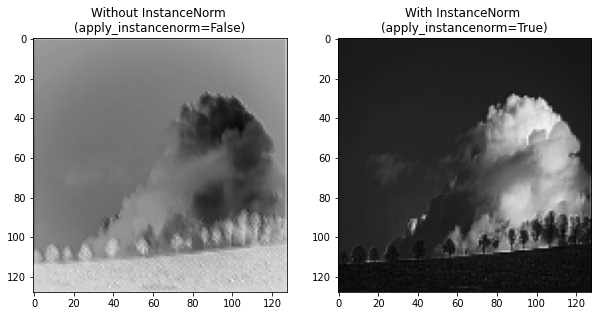

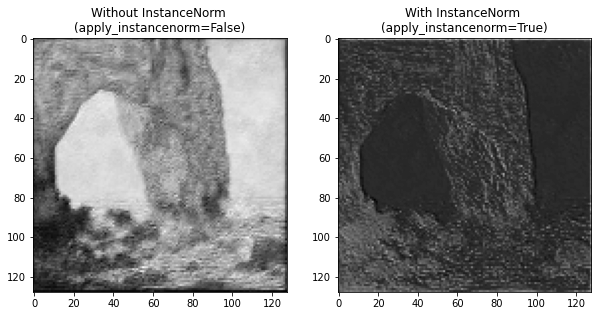

In [12]:
def test_instancenorm(input_image):
    # `apply_instancenorm=False`
    downsample_no_norm = downsample(64, 4, apply_instancenorm=False)
    output_no_norm = downsample_no_norm(input_image)
    
    # `apply_instancenorm=True`
    downsample_with_norm = downsample(64, 4, apply_instancenorm=True)
    output_with_norm = downsample_with_norm(input_image)
    
    # plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(output_no_norm[0, :, :, 0], cmap='gray')  # 1つのチャネルのみ可視化
    axes[0].set_title("Without InstanceNorm \n(apply_instancenorm=False)")
    
    axes[1].imshow(output_with_norm[0, :, :, 0], cmap='gray')  # 1つのチャネルのみ可視化
    axes[1].set_title("With InstanceNorm \n(apply_instancenorm=True)")
    
    plt.show()

input_photo = example_photo[0] * 0.5 + 0.5 # (256,256,3)
input_photo = tf.expand_dims(input_photo, axis=0) # (1,256,256,3)

input_monet = example_monet[0] * 0.5 + 0.5 # (256,256,3)
input_monet = tf.expand_dims(input_monet, axis=0) # (1,256,256,3)

test_instancenorm(input_photo)
test_instancenorm(input_monet)

Here, I wanted to emphasize that applying instanceNorm at the very beginning of U-Net poses a risk of losing basic and/or important features right from the start.  

Comparing the images with and without instanceNorm does not fully illustrate how much information is lost or retained, unfortunately.  

This becomes more apparent when we generate images using cycleGAN. When instanceNorm is not applied at the beginning, the resulting images shall be better. Please stay tuned for that.

# Discriminator  
The discriminator is a neural network trained to distinguish between real images from the dataset and fake images generated by the generator.  

# The PatchGAN  
PatchGAN does not make judgments on the entire image but instead evaluates small local regions. For example, instead of determining whether a 256×256 image is entirely fake or real, it makes decisions at the level of small patches, such as 70×70 regions. A patch corresponds to a "receptive field".  

By making these local judgments, PatchGAN can capture high-frequency components (such as edges and textures), enhancing the realism of fine details. The final decision is made by averaging the scores from all patches. This approach is referred to as PatchGAN.  

# Three Times Downsampling  
In this implementation, the discriminator applies three downsampling operations, reducing the dimensions of the feature map and ultimately outputting a 30×30 score map.  

Here, note that 30×30 refers to the score map, not the patch size. The patch corresponds to the receptive field of each cell in the 30×30 score map, meaning each cell evaluates a 70×70 region of the original image.  

In this case, the patch size is 70×70, and features are extracted from this limited region using downsampling (typically via strided convolution). Finally, each patch receives a single score (probability).  

The 30×30 score map consists of individual cells, each assigned a score based on its receptive field.  

If the input image size is larger or smaller, the number of downsampling operations is adjusted to output an appropriately scaled score map. For example, a larger image requires more downsampling steps, while a smaller image requires fewer.

In [13]:
def Discriminator():
    # initializer for initializing weights for Conv and InstanceNorm layers
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Input size: 256H x 256W x 3Ch
    inp = layers.Input(shape=[256,256,3], name='input_image')

    # downsample() function contains conv layer + instanceNorm layer
    # downsample() function will decrease the image size by half.
    # downsample(#_of_filters , kernel_size, apply_instancenorm=True)
    down1 = downsample(64, 4, False)(inp) # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (batch_size, 32, 32, 256)

    # zero-padding adjusts the image size not to lose the feature on edges of our images
    zero_pad1 = layers.ZeroPadding2D()(down3) # padded to (batch_size, 34, 34, 256)
    # space map: (34 - 4 + 1)/1 = 31
    # Conv2D(#_of_filters ,kernel_size=4, strides=1, padding='valid'(means no padding),...)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    # instantiate the instanceNorm layer
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    # activation
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # padded to (bs, 33, 33, 256)
    # last layer outputs 1 channel vector, 
    # which represents the probability of 'real' or 'fake' for each pixel
    # space map: (33 - 4 + 1)/1 = 30
    last = layers.Conv2D(1, 4, strides=1, 
                         kernel_initializer=initializer)(zero_pad2) # (bs,30,30,1)
    # We have 30x30x1 tensors, which the discriminator will use its mean to judge an input image
    
    # define a model and return it
    return tf.keras.Model(inputs=inp, outputs=last)

# Distribute Learning

There are mainly two types of distributed learning: "data parallelism" and "model parallelism."

Data parallelism is used for large datasets, such as high-resolution images or massive amounts of text (e.g., Common Crawl).  

Data parallelism distributes a single model across multiple devices (GPUs), allowing the parameters of a data batch (e.g., weights and biases gradients) to be updated in parallel.

Model parallelism is used for massive models, such as GPTs or BERT, which are trained by distributing different weights and biases across different GPUs.

In this code, the 'strategy' for the 'tf.strategy.scope' is defined in the very first cell, within the "try ~ except ~" block. That is a typical code structure for allocating the TPU whenever it is available.
(Additionaly, it is required to mannally select the 'TPU' from the settings -> Accerelator).

Strategy.scope creates variables, such as weights and biases, and distributes replicas (copies) of a single model across multiple GPUs (referred to as "workers") . Each worker trains independently, shares gradient updates synchronously, and performs a 'reduce' operation on the data.

The 'reduce' operation refers to the process of integrating the calculated results from the workers in a synchronized manner.

Resource:  
Multi-GPU and distributed training  
https://www.tensorflow.org/guide/keras/distributed_training

In [14]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to fake monet paintings.
    photo_generator = Generator() # transforms real Monet paintings to fake photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and fake Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and fake photos

Since our generators are not trained yet, the generated fake Monet painting does not show what is expected at this point.

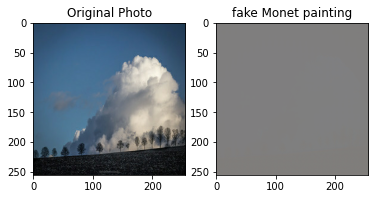

In [15]:
to_monet = monet_generator(example_photo)


plt.subplot(1, 2, 1)
plt.title('Original Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.subplot(1, 2, 2)
plt.title('fake Monet painting')
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# tf.GradientTape

`GradientTape` is an API for automatic differentiation. It defines the scope of gradient calculation, meaning it records operations and variables involved in the computation.

In the cell below, the following line:
`with tf.GradientTape(persistent=True) as tape:`
includes `"persistent=True"`.

By default, `persistent=False`, which means that once we call `tape.gradient()`, the tape ---essentially a computational graph for gradients---, is deleted and can no longer be used.  

Setting `persistent=True` keeps the tape intact, allowing us to call `tape.gradient()` multiple times during training.  
(until we call `del tape` to delete it, to release our memory).   

Resource:  
https://www.tensorflow.org/guide/autodiff

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        # loss weight for cycle-consistency loss
        lambda_cycle=8,  
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile( # set optimizer, loss function, evaluation metices
        self,
        m_gen_optimizer,  # monet_generator's optimizer
        p_gen_optimizer,  # photo_generator's optimizer
        m_disc_optimizer, # monet_discriminator's optimizer
        p_disc_optimizer, # photo_discriminator's optimizer
        gen_loss_fn,      # generator's loss function
        disc_loss_fn,     # discriminator's loss function
        cycle_loss_fn,    # cycle loss function 
        identity_loss_fn  # identity loss function
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # cycle steps: x -> y -> x
            # fake_monet = G(real_photo)
            fake_monet = self.m_gen(real_photo, training=True)
            # cycled_photo = F(G(real_photo)) 
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            # cycle steps: y -> x -> y
            # fake_photo = F(real_monet)  
            fake_photo = self.p_gen(real_monet, training=True)
            # cycled_monet = G(F(real_monet))
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            # identity mapping: to preserve the color of the input images
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator output
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Generator adversarial loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Cycle consistency loss
            # Forward cycle-consistency loss: x -> G(x) -> F(G(x)) ≈ x
            # Backward cycle-consistency loss: y -> F(y) -> G(F(y)) ≈ y
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Get the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        # Update the weights of the generator
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))
        
        # Update the weights of the discriminator
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# CycleGAN architecture  
We have two sets of data:  
- "real **photo dataset** `X`", and a  
- "real **Monet painting** dataset `Y`".  

We also have two generators:  
- The generator `G` takes a real photo $x_{i}$ as input and generates a fake Monet painting ($\hat y_{i}$ = $G(x_{i})$).  
- The generator `F` takes a real Monet painting $y_{i}$ as input, and generates a fake photo ($\hat x_{i}$ = $F(y_{i})$). 

Additionally, there are two discriminators:  
- $D_{X}$ determines whether an input `x` is a real photo or not.  
- $D_{Y}$ determines whether an inputs `y` is a real Monet painting or not.

# Adversarial Loss

The primary goal of the discriminators is to predict **'real'** for genuine images and **'fake'** for generated images.

This is formulated as:
$$
\mathcal{L}_{\text{GAN}}(G, D_{Y}, X, Y) = \mathbb{E}_{y \sim P_{\text{data}}(y)} \left[ \log D_{Y}(y) \right] + \mathbb{E}_{x \sim P_{\text{data}}(x)} \left[ \log (1 - D_{Y}(G(x))) \right]
$$
where:  

$D_{Y}(y)$: The discriminator's probability of predicting 'real Monet' for an input $y$ (a real Monet painting; it is correct prediction).  
  
$G(x)$: The generator's output,  generating a 'fake Monet' from an input $x$ (a real photo). 

$D_{Y}(G(x))$: The discriminator's probability of predicting 'real Monet' for an input $G(x)$ (a fake Monet; it is wrong prediction). 

$1-D_{Y}(G(x))$: The discriminator's probability of predicting 'fake Monet' for an input $G(x)$ (a fake Monet; it is correct prediction). 

In [17]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        
        return total_disc_loss * 0.5

# Generator loss

In [18]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

# Cycle Consistency Loss

We cycle an input image between two generators and aim to minimize the **cycle consistency loss** such that $F(G(x)) ≈ x$ and $G(F(y)) ≈ y$.  

Cycle Consistency Loss measures the distance between a generated image and the corresponding real image.  

In the expression below,  
$F(G(x)) - x$  
the first term F(G(x)) represents the cycled image;  
x: photo ~> G(x): fake Monet ~> F(G(x)): cycled photo

We aim to minimize this distance as much as possible so that the discriminator has a harder time to distinguishing between them.
  
$$
\mathcal{L}_{cycle}(G, F) =
\mathbb{E}_{x \sim P_{\text{data}}(x)}
\left[ ||F(G(x)) - x||_1 \right] +
\mathbb{E}_{y \sim P_{\text{data}}(y)}
\left[ ||G(F(y)) - y||_1 \right]
$$  
  
$G$: generator (photo -> monet),  
$F$: generator (monet -> photo),  
$x \sim P_{data}(x)$: real photo distribution,  
$y \sim P_{data}(y)$: real Monet distribution,  
$||・||_{1}$: L1 norm (MAE: Mean Absolute Error)  

In [19]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

# Identity loss
Here, we add another loss function, the identity loss. This loss measures the error between the generated image and the original image, helping the Generator learn to maintain the color tone of the image.  

Without the identity loss, even if the Generator can produce images that resemble the original, it might fail to preserve the color tone properly, such as the sky turning red, or the sea turning yellow.  

To prevent this, the identity loss is effective.  

The identity loss is expressed by the following equation:

$$
\mathcal{L}_{identity}(G, F) =
\mathbb{E}_{x \sim P_{\text{data}}(x)}
\left[ ||F(x) - x||_1 \right] +
\mathbb{E}_{y \sim P_{\text{data}}(y)}
\left[ ||G(y) - y||_1 \right]
$$  

In [20]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        # We apply a weaker LAMBDA for the identity loss, by multiplying 0.5
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [21]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    #epochs=25
    epochs=5
)

Epoch 1/5
300/300 [==============================] - 116s 246ms/step - monet_gen_loss: 4.2535 - photo_gen_loss: 4.4782 - monet_disc_loss: 0.6723 - photo_disc_loss: 0.6161
Epoch 2/5
300/300 [==============================] - 75s 246ms/step - monet_gen_loss: 3.0663 - photo_gen_loss: 3.2326 - monet_disc_loss: 0.6618 - photo_disc_loss: 0.6098
Epoch 3/5
300/300 [==============================] - 75s 246ms/step - monet_gen_loss: 3.0699 - photo_gen_loss: 3.2764 - monet_disc_loss: 0.6557 - photo_disc_loss: 0.6012
Epoch 4/5
300/300 [==============================] - 75s 246ms/step - monet_gen_loss: 2.9927 - photo_gen_loss: 3.2835 - monet_disc_loss: 0.6499 - photo_disc_loss: 0.5658
Epoch 5/5
300/300 [==============================] - 74s 246ms/step - monet_gen_loss: 2.8947 - photo_gen_loss: 3.1075 - monet_disc_loss: 0.6381 - photo_disc_loss: 0.6073


# Visualize our Monet-esque photos

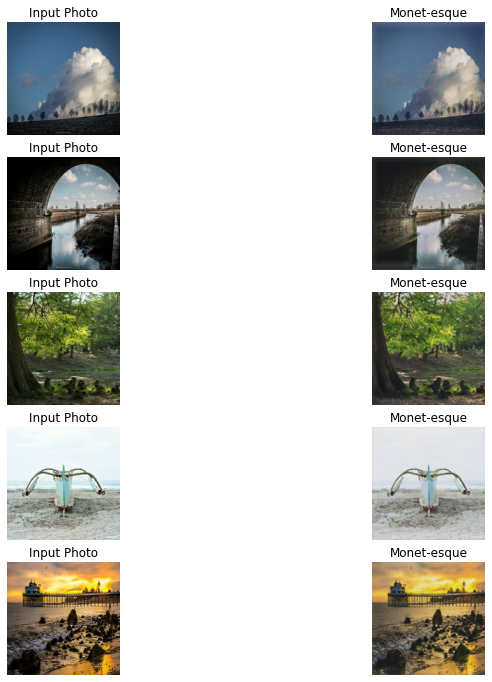

In [24]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Conclusion & Analysis  

The LAMBDA for the cycle-concistency and identity losses is important hyperparameter.  
In the original cycleGAN paper, it was set to 10 . In this code, I tested values of 8, 10, and 12, with LAMBDA = 8 yielding the best results:

| **LAMBDA** | **monet_gen_loss** | **photo_gen_loss** | **monet_disc_loss** | **photo_disc_loss** |
|------------|--------------------|--------------------|---------------------|---------------------|
| 8          | 2.8941              | 2.9720              | 0.6323              | 0.6246              |
| 10         | 3.2847              | 3.3653              | 0.6294              | 0.6132              |
| 12         | 3.8285              | 4.0929              | 0.6338              | 0.5853              |  

A smaller generator loss indicates that the generator more effectively deceives the discriminator.
The ideal discriminator loss is at 0.5, which signifies that the discriminator cannot distinguish between real and fake images, essentially guessing at random.
Although our discriminator losses are slightly above this ideal range, they consistency fall between 0.60 and 0.63 across all tested models.

To improve the results further, increasing the number of epochs would likely reduces losses.
 
Additionally, exploring alternative loss functions, trying different optimizers, or adjusting the patchGAN discriminator size could enhance the model's performance.

Thank you for reading! I look forward to refining these results further.

# Create submission file

In [25]:
import PIL
! mkdir ../images

In [26]:
i = 1
for img in photo_ds:
    # converting an image to Monet-style. training=False sets the model inference mode instead of training mode.
    prediction = monet_generator(img, training=False)[0].numpy()
    # rescaling the normalized data back to the original size by multiplying 127.5
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [27]:
# importing an utility library to zip the images
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Resources
Monet CycleGAN Tutorial by Amy Jang  
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial  


Unpaired Image-to-Image Translation
using Cycle-Consistent Adversarial Networks  
arXiv:1703.10593  

Image-to-Image Translation with Conditional Adversarial Networks  
arXiv:1611.07004  

A technical report on convolution arithmetic in the context of deep learning  
https://github.com/vdumoulin/conv_arithmetic  

A guide to receptive field arithmetic for Convolutional Neural Networks  
https://blog.mlreview.com/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807  